# Import Library

In [223]:
import calendar
import folium
import requests
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import io
import base64
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from matplotlib import animation
from matplotlib import cm
from IPython.display import HTML
from subprocess import check_output
from sklearn.cluster import KMeans
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error, r2_score,silhouette_score
from dateutil import parser
from geopy.geocoders import Nominatim
from scipy.spatial.distance import cdist
from yellowbrick.cluster import KElbowVisualizer

pd.set_option('display.max_column',None)

# Import Data

In [224]:
df = pd.read_csv('dummy-transaksi-ojol-need-clean.csv',sep=';')

df = df.drop(columns=['id','customer_id','driver_id','merchant_id'])

df.head()

,date,mode,from_alamat,from_kelurahan,from_kecamatan,from_latlng,to_alamat,to_kelurahan,to_kecamatan,to_latlng,distance,amount_delivery,amount_merchant,transaction_amount_total,customer_gender,customer_birthdate,driver_gender,driver_birthdate,kendaraan_jenis,kendaraan_merk,merchant_name,merchant_category
0,2019/03/09 20:45 s/d 2019/03/09 19:55,BIKE,"Gang Ikhwan No.16, Sungai Jawi",DARAT SEKIP,PONTIANAK KOTA,"-0,0303277,109,297753","Jl. Prof. M.Yamin No.3a, Sungai Bangkong",BENUA MELAYU LAUT,PONTIANAK SELATAN,"-0,061345224,109,305406",5.55,2500,0,2500,P,1994-02-05T00:00:00,L,1997-03-24T00:00:00,MOTOR,Yamaha,NaN,NaN
1,2019/03/09 19:55 s/d 2019/03/09 19:54,FOOD,"Neo Shabu-Shabu Steak & Shake, Johar, Jl. Joha...",SUNGAI BANGKONG,PONTIANAK KOTA,"-0,02861,109,329253","Jl. Dare Nandong Villa Ria Indah, Tj. Hulu",BANJAR SERASAN,PONTIANAK TIMUR,"-0,028571215,109,3749533",7.08,9000,82000,91000,L,2004-04-22T00:00:00,L,1976-07-26T00:00:00,MOTOR,BMW,"Neo Shabu-Shabu Steak & Shake, Johar",RESTAURANT
2,2019/03/09 19:54 s/d 2019/03/09 18:56,SHOP,"Alfamart Pontianak Mall, Jl Teuku Umar",DARAT SEKIP,PONTIANAK KOTA,"-0,0301863,109,3356331","Gg. Gn. Malabar No.21, Sungai Jawi",SUNGAI BELIUNG,PONTIANAK BARAT,"-0,022623361,109,3191522",4.02,5000,58500,63500,L,2000-01-07T00:00:00,L,1985-12-28T00:00:00,MOTOR,TVS,Alfamart Pontianak Mall,TOKO/SWALAYAN
3,2019/03/09 18:56 s/d 2019/03/09 12:28,FOOD,"Parklife, Jl. Karimata No.64, Sungai Bangkong,...",MARIANA,PONTIANAK KOTA,"-0,0305815,109,3264009","Unnamed Road, Pal IX",BANGKA BELITUNG DARAT,PONTIANAK TENGGARA,"-0,063780195,109,273496",8.94,12000,72000,84000,L,1987-08-02T00:00:00,L,1993-06-10T00:00:00,MOTOR,Suzuki,Parklife,CAFE
4,2019/03/09 12:28 s/d 2019/03/08 18:25,CAR,"Jl. Tabrani Ahmad No.12, Sungai Jawi Dalam",PAL LIMA,PONTIANAK BARAT,"-0,018461872,109,3075679","Pal IX, Kakap River",BANSIR LAUT,PONTIANAK TENGGARA,"-0,05923926,109,2731293",7.93,14400,0,14400,L,2004-01-23T00:00:00,P,1988-05-02T00:00:00,MOBIL,Honda,NaN,NaN


# Data Understanding

In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017 entries, 0 to 1016
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      1017 non-null   object 
 1   mode                      1017 non-null   object 
 2   from_alamat               1017 non-null   object 
 3   from_kelurahan            1017 non-null   object 
 4   from_kecamatan            1017 non-null   object 
 5   from_latlng               1017 non-null   object 
 6   to_alamat                 1014 non-null   object 
 7   to_kelurahan              1017 non-null   object 
 8   to_kecamatan              1017 non-null   object 
 9   to_latlng                 1017 non-null   object 
 10  distance                  1017 non-null   float64
 11  amount_delivery           1017 non-null   int64  
 12  amount_merchant           1017 non-null   int64  
 13  transaction_amount_total  1017 non-null   int64  
 14  customer

In [226]:
df['mode'].value_counts()

BIKE    325
FOOD    265
CAR     242
SHOP    185
Name: mode, dtype: int64

In [227]:
df.groupby(['mode','kendaraan_jenis','kendaraan_merk']).count()

date  from_alamat  from_kelurahan  \
mode kendaraan_jenis kendaraan_merk                                      
BIKE MOTOR           BMW               73           73              73   
                     Honda             60           60              60   
                     Kawasaki          54           54              54   
                     Suzuki            30           30              30   
                     TVS               54           54              54   
                     Yamaha            54           54              54   
CAR  MOBIL           Audi              26           26              26   
                     BMW               31           31              31   
                     Honda             64           64              64   
                     KIA               35           35              35   
                     Mitsubishi        33           33              33   
                     Toyota            28           28              28   
                     Volvo             25           25              25   
FOOD MOTOR           BMW               71           71              71   
                     Honda             48           48              48   
                     Kawasaki          36           36              36   
                     Suzuki            26           26              26   
                     TVS               45           45              45   
                     Yamaha            39           39              39   
SHOP MOTOR           BMW               41           41              41   
                     Honda             38           38              38   
                     Kawasaki          32           32              32   
                     Suzuki            28           28              28   
                     TVS               22           22              22   
                     Yamaha            24           24              24   

                                     from_kecamatan  from_latlng  to_alamat  \
mode kendaraan_jenis kendaraan_merk                                           
BIKE MOTOR           BMW                         73           73         73   
                     Honda                       60           60         60   
                     Kawasaki                    54           54         53   
                     Suzuki                      30           30         30   
                     TVS                         54           54         54   
                     Yamaha                      54           54         54   
CAR  MOBIL           Audi                        26           26         25   
                     BMW                         31           31         31   
                     Honda                       64           64         64   
                     KIA                         35           35         35   
                     Mitsubishi                  33           33         33   
                     Toyota                      28           28         28   
                     Volvo                       25           25         25   
FOOD MOTOR           BMW                         71           71         71   
                     Honda                       48           48         48   
                     Kawasaki                    36           36         36   
                     Suzuki                      26           26         26   
                     TVS                         45           45         45   
                     Yamaha                      39           39         39   
SHOP MOTOR           BMW                         41           41         41   
                     Honda                       38           38         37   
                     Kawasaki                    32           32         32   
                     Suzuki                      28           28         28   
                     TVS                         22           2

In [228]:
df['merchant_category'].value_counts()

TOKO/SWALAYAN    185
CAFE             113
WARUNG MAKAN      76
RESTAURANT        42
JAJANAN           34
Name: merchant_category, dtype: int64

In [229]:
df['merchant_name'].value_counts()

Alfamart Siantan Hulu       27
Indomaret teuku umar        26
Indomaret Siantan Hilir     24
Indomaret Kota Baru         24
Alfamart Pontianak Mall     22
                            ..
The Flame Grill N Sizzle     2
Canopy Center                2
Raja Uduk                    2
Kings' Kitchen and Bar       1
Pondok Rasa                  1
Name: merchant_name, Length: 78, dtype: int64

In [230]:
df.groupby(['mode','merchant_name','merchant_category']).count()

date  from_alamat  \
mode merchant_name            merchant_category                      
FOOD  Siobi Pontianak         CAFE                  2            2   
     A Ngow Juice             JAJANAN               4            4   
     A&W, Ayani Megamall      RESTAURANT            3            3   
     Ayam Dadakan, Teuku Umar WARUNG MAKAN          4            4   
     B?tani Cafe & Resto      CAFE                  3            3   
...                                               ...          ...   
SHOP Indomaret Jalan karet    TOKO/SWALAYAN        13           13   
     Indomaret Komyos Sudarso TOKO/SWALAYAN        14           14   
     Indomaret Kota Baru      TOKO/SWALAYAN        24           24   
     Indomaret Siantan Hilir  TOKO/SWALAYAN        24           24   
     Indomaret teuku umar     TOKO/SWALAYAN        26           26   

                                                 from_kelurahan  \
mode merchant_name            merchant_category                   
FOOD  Siobi Pontianak         CAFE                            2   
     A Ngow Juice             JAJANAN                         4   
     A&W, Ayani Megamall      RESTAURANT                      3   
     Ayam Dadakan, Teuku Umar WARUNG MAKAN                    4   
     B?tani Cafe & Resto      CAFE                            3   
...                                                         ...   
SHOP Indomaret Jalan karet    TOKO/SWALAYAN                  13   
     Indomaret Komyos Sudarso TOKO/SWALAYAN                  14   
     Indomaret Kota Baru      TOKO/SWALAYAN                  24   
     Indomaret Siantan Hilir  TOKO/SWALAYAN                  24   
     Indomaret teuku umar     TOKO/SWALAYAN                  26   

                                                 from_kecamatan  from_latlng  \
mode merchant_name            merchant_category                                
FOOD  Siobi Pontianak         CAFE                            2            2   
     A Ngow Juice             JAJANAN                         4            4   
     A&W, Ayani Megamall      RESTAURANT                      3            3   
     Ayam Dadakan, Teuku Umar WARUNG MAKAN                    4            4   
     B?tani Cafe & Resto      CAFE                            3            3   
...                                                         ...          ...   
SHOP Indomaret Jalan karet    TOKO/SWALAYAN                  13           13   
     Indomaret Komyos Sudarso TOKO/SWALAYAN                  14           14   
     Indomaret Kota Baru      TOKO/SWALAYAN                  24           24   
     Indomaret Siantan Hilir  TOKO/SWALAYAN                  24           24   
     Indomaret teuku umar     TOKO/SWALAYAN                  26           26   

                                                 to_alamat  to_kelurahan  \
mode merchant_name            merchant_category                            
FOOD  Siobi Pontianak         CAFE                       2             2   
     A Ngow Juice             JAJANAN                    4             4   
     A&W, Ayani Megamall      RESTAURANT                 3             3   
     Ayam Dadakan, Teuku Umar WARUNG MAKAN               4             4   
     B?tani Cafe & Resto      CAFE                       3             3   
...                                                    ...           ...   
SHOP Indomaret Jalan karet    TOKO/SWALAYAN             13            13   
     Indomaret Komyos Sudarso TOKO/SWALAYAN             14            14   
     Indomaret Kota Baru      TOKO/SWALAYAN             24            24   
     Indomaret Siantan Hilir  TOKO/SWALAYAN             24            24   
     Indomaret teuku umar     TOKO/SWALAYAN             26            26   

                                                 to_kecamatan  to_latlng  \
mode merchant_name            merchant_category                            
FOOD  Siobi Pontianak         CAFE                          2          2   
     A N

# Data Preprocessing

In [231]:
#Rekontruksi nilai date (s/d) menjadi pickup dan dropoff date
date = []
for i in df['date']:
    date.append([date for date in i.split(' s/d ')])
df_date = pd.DataFrame(date, columns=['pickup_date', 'dropoff_date'])

df = pd.concat([df,df_date], axis=1)


In [232]:
pickup_hour = df.pickup_date.apply(lambda x: parser.parse(x).hour )

In [233]:
# Ubah format string menjadi objek datetime
df['customer_birthdate'] = pd.to_datetime(df['customer_birthdate'], format='%Y-%m-%dT%H:%M:%S')

df['driver_birthdate'] = pd.to_datetime(df['driver_birthdate'], format='%Y-%m-%dT%H:%M:%S')

In [234]:
# Fungsi untuk mengelompokkan umur ke dalam golongan
def golongan_umur(x):
    if x < 18:
        return 'Anak-anak'
    elif x < 30:
        return 'Muda'
    elif x < 50:
        return 'Dewasa'
    else:
        return 'Lansia'
    
# Hitung umur dalam tahun
now = datetime.datetime.now()
df['umur_customer'] = (now - df['customer_birthdate']).apply(lambda x: x.days // 365)
df['umur_driver'] = (now - df['driver_birthdate']).apply(lambda x: x.days // 365)

df['golongan_customer'] = df['umur_customer'].apply(golongan_umur)
df['golongan_driver'] = df['umur_driver'].apply(golongan_umur)

df = df.drop(columns=['date','customer_birthdate','driver_birthdate'])

In [235]:
a =list(df['from_latlng'])
pick = pd.DataFrame({'a': a})

pick = pick['a'].str.split('[,.]', expand=True)
df['pickup_lat'] = pick[0]+'.'+pick[1]
df['pickup_long'] = pick[2]+'.'+pick[3]

b =list(df['to_latlng'])
dropoff = pd.DataFrame({'b': b})

dropoff = dropoff['b'].str.split('[,.]', expand=True)
df['dropoff_lat'] = dropoff[0]+'.'+dropoff[1]
df['dropoff_long'] = dropoff[2]+'.'+dropoff[3]


In [236]:
df = df.drop(['from_latlng','to_latlng'],axis=1)
df = df[df['pickup_long'] != '109.3272303 \t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t-0']
df = df[df['pickup_lat'] != "-6.3653643"]
df = df[df['pickup_lat'] != "NaN"]

df = df[df['dropoff_date']!="1900/01/00 00:00"]

In [237]:
# # Inisialisasi geolocator
# geolocator = Nominatim(user_agent="my-app")

# # Fungsi untuk mendapatkan postal code Geopy
# def get_postal_code(x, y):
#     location = geolocator.reverse((x, y))
#     try:
#         postal_code = location.raw['address']['zip']
#     except KeyError:
#         postal_code = 'Not found'
#     return postal_code

# # Menambahkan kolom 'postal_code' ke dataframe
# df['postal_code_pickup'] = df.apply(lambda row: get_postal_code(row['pickup_lat'], row['pickup_long']), axis=1)
# df['postal_code_dropoff'] = df.apply(lambda row: get_postal_code(row['dropoff_lat'], row['dropoff_long']), axis=1)

# # Fungsi untuk mendapatkan postal code API
# def get_postal_code(lat, long):
#     url = f"https://nominatim.openstreetmap.org/reverse?format=jsonv2&lat={lat}&lon={long}"
#     response = requests.get(url).json()
#     try:
#         postal_code = response['address']['postcode']
#     except KeyError:
#         postal_code = 'Not found'
#     return postal_code


In [238]:
df['pickup_date'] = pd.to_datetime(df['pickup_date'], format='%Y-%m-%dT%H:%M:%S')

df['dropoff_date'] = pd.to_datetime(df['dropoff_date'], format='%Y-%m-%dT%H:%M:%S')

In [239]:
# Hitung selisih waktu antara kedua waktu dan simpan di kolom baru
df['tempuh'] = df['pickup_date'] - df['dropoff_date']

# Hitung selisih waktu dalam menit dan simpan di kolom baru
Estimasi = df['tempuh'].apply(lambda x: int(x.total_seconds())).abs()

In [240]:
Jam = df.pickup_date.dt.hour
Hari = df['pickup_date'].dt.day
Bulan = df['pickup_date'].dt.month

df['Estimasi'] = Estimasi
df['Jam'] = Jam
df['Hari'] = Hari
df['Bulan'] = Bulan
df['Waktu'] = pd.cut(df['Jam'], bins=[0, 12, 15,18, 24], labels=['Pagi', 'Siang','Sore', 'Malam'])

In [241]:
#convert distance (km) to (m)
df['distance'] = df['distance'].values*100

In [242]:
df['pickup_lat'] = [float(i) for i in df['pickup_lat']]
df['pickup_long'] = [float(i) for i in df['pickup_long']]
df['dropoff_lat'] = [float(i) for i in df['dropoff_lat']]
df['dropoff_long'] = [float(i) for i in df['dropoff_long']]

In [243]:
df = df.drop(columns=['tempuh'])

In [244]:
df.head()

,mode,from_alamat,from_kelurahan,from_kecamatan,to_alamat,to_kelurahan,to_kecamatan,distance,amount_delivery,amount_merchant,transaction_amount_total,customer_gender,driver_gender,kendaraan_jenis,kendaraan_merk,merchant_name,merchant_category,pickup_date,dropoff_date,umur_customer,umur_driver,golongan_customer,golongan_driver,pickup_lat,pickup_long,dropoff_lat,dropoff_long,Estimasi,Jam,Hari,Bulan,Waktu
0,BIKE,"Gang Ikhwan No.16, Sungai Jawi",DARAT SEKIP,PONTIANAK KOTA,"Jl. Prof. M.Yamin No.3a, Sungai Bangkong",BENUA MELAYU LAUT,PONTIANAK SELATAN,555.0,2500,0,2500,P,L,MOTOR,Yamaha,NaN,NaN,2019-03-09 20:45:00,2019-03-09 19:55:00,29,26,Muda,Muda,-0.030328,109.297753,-0.061345,109.305406,3000,20,9,3,Malam
1,FOOD,"Neo Shabu-Shabu Steak & Shake, Johar, Jl. Joha...",SUNGAI BANGKONG,PONTIANAK KOTA,"Jl. Dare Nandong Villa Ria Indah, Tj. Hulu",BANJAR SERASAN,PONTIANAK TIMUR,708.0,9000,82000,91000,L,L,MOTOR,BMW,"Neo Shabu-Shabu Steak & Shake, Johar",RESTAURANT,2019-03-09 19:55:00,2019-03-09 19:54:00,18,46,Muda,Dewasa,-0.028610,109.329253,-0.028571,109.374953,60,19,9,3,Malam
2,SHOP,"Alfamart Pontianak Mall, Jl Teuku Umar",DARAT SEKIP,PONTIANAK KOTA,"Gg. Gn. Malabar No.21, Sungai Jawi",SUNGAI BELIUNG,PONTIANAK BARAT,402.0,5000,58500,63500,L,L,MOTOR,TVS,Alfamart Pontianak Mall,TOKO/SWALAYAN,2019-03-09 19:54:00,2019-03-09 18:56:00,23,37,Muda,Dewasa,-0.030186,109.335633,-0.022623,109.319152,3480,19,9,3,Malam
3,FOOD,"Parklife, Jl. Karimata No.64, Sungai Bangkong,...",MARIANA,PONTIANAK KOTA,"Unnamed Road, Pal IX",BANGKA BELITUNG DARAT,PONTIANAK TENGGARA,894.0,12000,72000,84000,L,L,MOTOR,Suzuki,Parklife,CAFE,2019-03-09 18:56:00,2019-03-09 12:28:00,35,29,Dewasa,Muda,-0.030582,109.326401,-0.063780,109.273496,23280,18,9,3,Sore
4,CAR,"Jl. Tabrani Ahmad No.12, Sungai Jawi Dalam",PAL LIMA,PONTIANAK BARAT,"Pal IX, Kakap River",BANSIR LAUT,PONTIANAK TENGGARA,793.0,14400,0,14400,L,P,MOBIL,Honda,NaN,NaN,2019-03-09 12:28:00,2019-03-08 18:25:00,19,34,Muda,Dewasa,-0.018462,109.307568,-0.059239,109.273129,64980,12,9,3,Pagi


### Missing Value

In [245]:
df.isnull().sum()

mode                          0
from_alamat                   0
from_kelurahan                0
from_kecamatan                0
to_alamat                     3
to_kelurahan                  0
to_kecamatan                  0
distance                      0
amount_delivery               0
amount_merchant               0
transaction_amount_total      0
customer_gender               0
driver_gender                 0
kendaraan_jenis               0
kendaraan_merk                0
merchant_name               567
merchant_category           567
pickup_date                   0
dropoff_date                  0
umur_customer                 0
umur_driver                   0
golongan_customer             0
golongan_driver               0
pickup_lat                    0
pickup_long                   0
dropoff_lat                   0
dropoff_long                  0
Estimasi                      0
Jam                           0
Hari                          0
Bulan                         0
Waktu   

In [246]:
#hapus missing value pada atribut alamat
df = df.dropna(subset=['to_alamat'])

#Convert NaN menjadi 'None'; atribut merchant_name & merchant_category
df = df.fillna('None')

In [247]:
pickup_lat = df['pickup_lat'].values
pickup_lat = df['pickup_lat'].values
dropoff_lat = df['dropoff_lat'].values
pickup_long = df['pickup_long'].values
dropoff_long = df['dropoff_long'].values

In [248]:
# xlim = [df.pickup_long.min(),df.dropoff_long.max()]
# ylim = [df.pickup_lat.min(),df.dropoff_lat.max()]
# xlim, ylim

In [249]:
# df = df[(df.pickup_long> xlim[0]) & (df.pickup_long < xlim[1])]
# df = df[(df.dropoff_long> xlim[0]) & (df.dropoff_long < xlim[1])]
# df = df[(df.pickup_lat> ylim[0]) & (df.pickup_lat < ylim[1])]
# df = df[(df.dropoff_lat> ylim[0]) & (df.dropoff_lat < ylim[1])]

### Handling Outlier

In [250]:
##Tidak Ikut Handling
df = df.drop(columns=['pickup_lat','dropoff_lat','pickup_long','dropoff_long'])

##### Sebelum

In [251]:
df.skew()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8076\1665899112.py:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.skew()


distance                    0.629951
amount_delivery             1.354650
amount_merchant             0.728447
transaction_amount_total    0.669282
umur_customer               0.420877
umur_driver                 0.145709
Estimasi                    2.002379
Jam                         0.052464
Hari                       -0.459674
Bulan                      -0.944928
dtype: float64

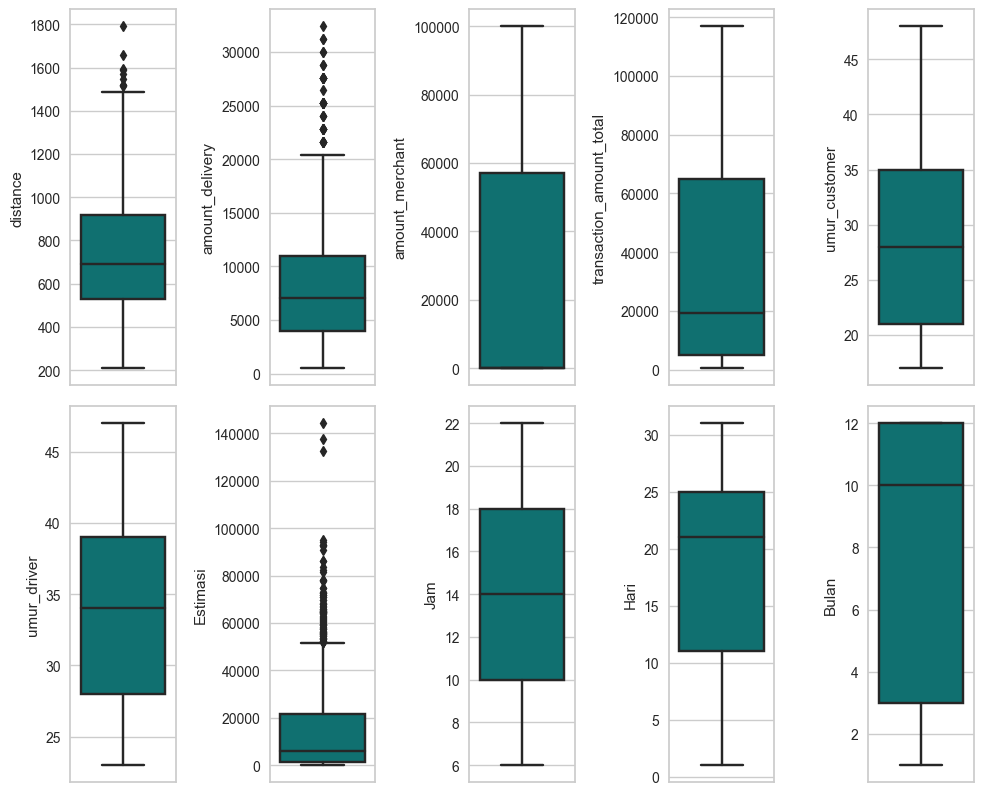

In [252]:
plt.figure(figsize=(10,20))

feat_num = df.select_dtypes(include=[np.number]).columns.tolist()

# plotting
for i in range(0, len(feat_num)):
    plt.subplot(5, 5, i+1)
    sns.boxplot(y=df[feat_num[i]],color='teal', orient='v')
    plt.tight_layout()

### Transformasi Log

In [253]:
# df['Estimasi'] = np.log10(df['Estimasi'] + 1)

# df['distance'] = np.log10(df['distance'] + 1)

# df['amount_delivery'] = np.log10(df['amount_delivery'] + 1)

# df['amount_merchant'] = np.log10(df['amount_merchant'] + 1)

# df['transaction_amount_total'] = np.log10(df['transaction_amount_total'] + 1)

for i in range(0, len(feat_num)):
    df[feat_num[i]] = np.log10(df[feat_num[i]]+1)

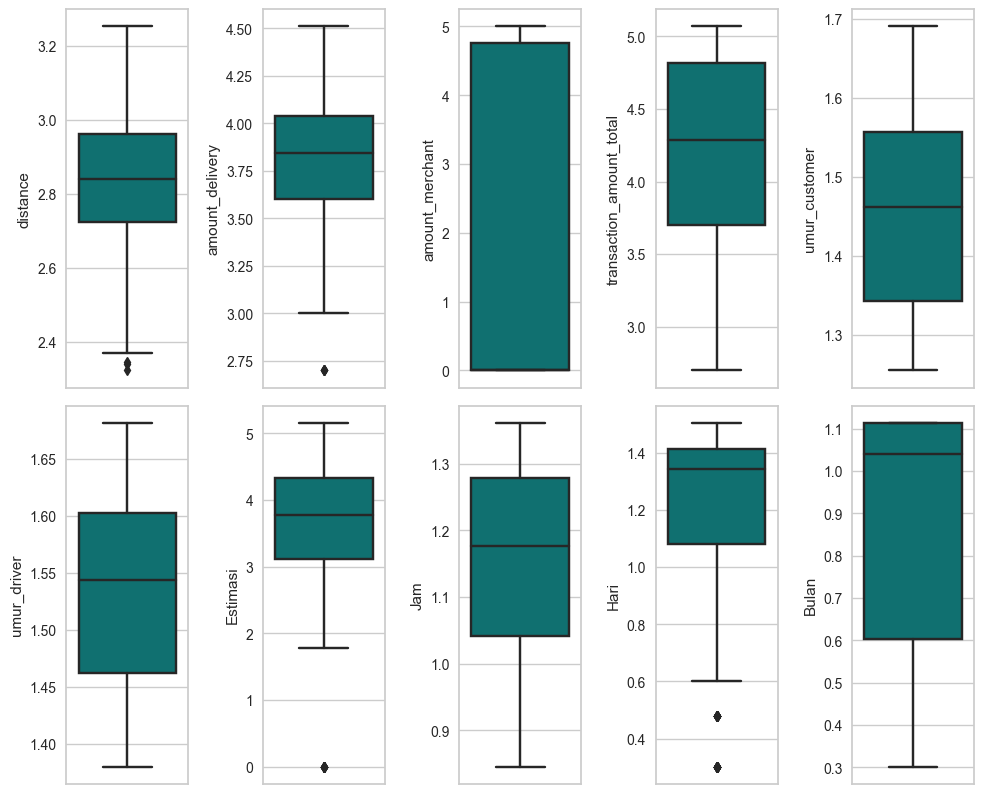

In [254]:
plt.figure(figsize=(10,20))

# plotting
for i in range(0, len(feat_num)):
    plt.subplot(5, 5, i+1)
    sns.boxplot(y=df[feat_num[i]],color='teal', orient='v')
    plt.tight_layout()

##### Imputasi Outlier

In [255]:
# def remove_outliers(df):
#     float_cols = df.select_dtypes(include=['float64']).columns.tolist()
#     int_cols = df.select_dtypes(include=['int64']).columns.tolist()
    
#     # Menghapus nilai outlier pada setiap atribut
#     for col in float_cols + int_cols:
#         Q1 = df[col].quantile(0.25)
#         Q3 = df[col].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5*IQR
#         upper_bound = Q3 + 1.5*IQR
        
#         if col in float_cols:
#             df = df[~((df[col] < lower_bound) | (df[col] > upper_bound))]
#         elif col in int_cols:
#             df = df[~((df[col] < lower_bound) | (df[col] > upper_bound))]
    
#     return df
# df = remove_outliers(df)

def impute_outliers(df):
    float_cols = df.select_dtypes(include=['float64']).columns.tolist()
    int_cols = df.select_dtypes(include=['int64']).columns.tolist()
    
    # Menghapus nilai outlier pada setiap atribut
    for col in float_cols + int_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5*IQR
        upper_bound = Q3 + 1.5*IQR
        
        if col in float_cols:
            df.loc[df[col] < lower_bound, col] = df[col].mean()
            df.loc[df[col] > upper_bound, col] = df[col].mean()
        elif col in int_cols:
            df.loc[df[col] < lower_bound, col] = df[col].mean()
            df.loc[df[col] > upper_bound, col] = df[col].mean()
    
    return df

df = impute_outliers(df)

# Normalisasi Data

In [256]:
scaler = MinMaxScaler()
num_df_transform = pd.DataFrame(scaler.fit_transform(df[feat_num]), columns=feat_num)

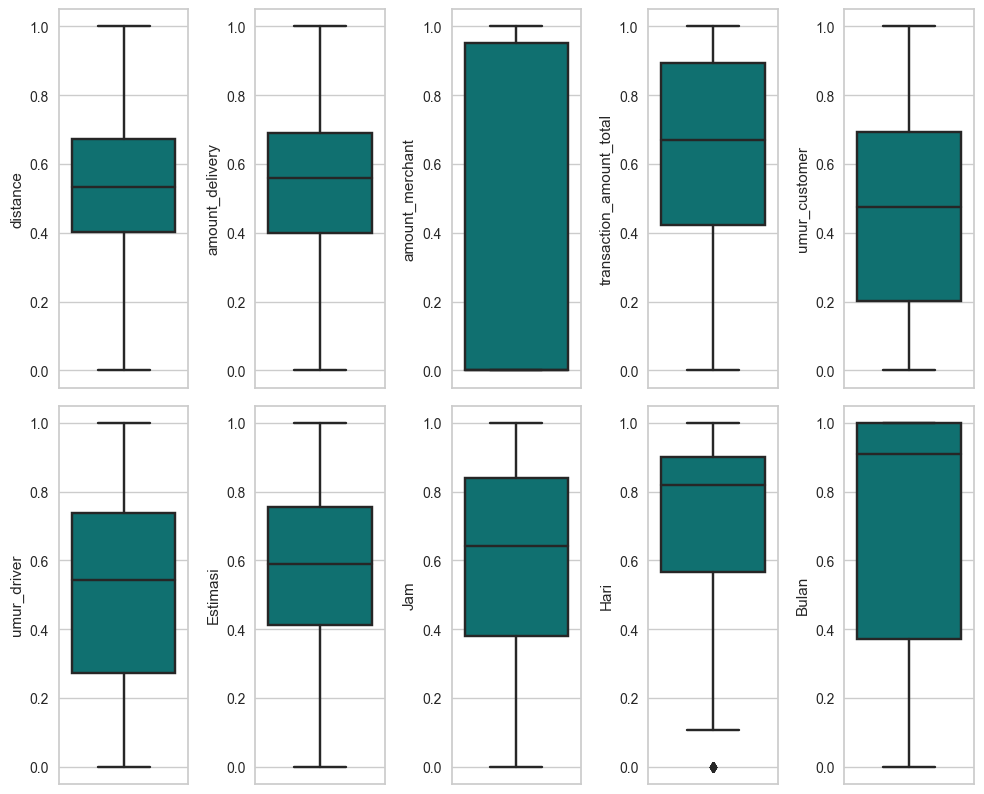

In [257]:
plt.figure(figsize=(10,20))
num_df_column = num_df_transform.columns
# plotting
for i in range(0, len(num_df_column)):
    plt.subplot(5, 5, i+1)
    sns.boxplot(y=num_df_transform[num_df_column[i]],color='teal', orient='v')
    plt.tight_layout()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8076\140573553.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(num_df_transform[var])
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8076\140573553.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(num_df_transform[var])
C:\Users\LENOVO\AppData\Lo

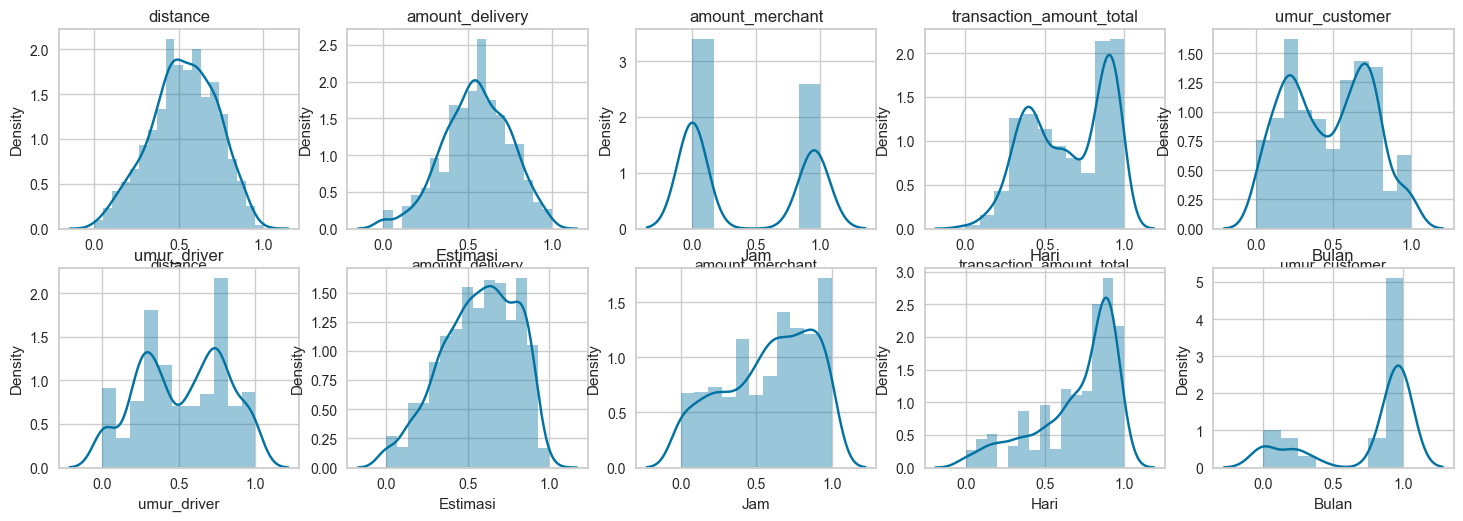

In [258]:
plt.figure(figsize=(18,15))

for i,var in enumerate(num_df_column):
    plt.subplot(5,5,i+1)
    sns.distplot(num_df_transform[var])
    plt.title(var)

# Data Aggregation (Clean)

In [259]:
var = df.select_dtypes(include=['object']).columns.tolist()

df = df[var]

df['pickup_lat'] = pickup_lat
df['pickup_lat'] = pickup_lat
df['pickup_long'] = pickup_long 
df['dropoff_lat'] = dropoff_lat 
df['dropoff_long'] = dropoff_long 

for i in range(0, len(feat_num)):
    df[feat_num[i]] = [j for j in num_df_transform[feat_num[i]]]

# feat_num

# Data Transformasi

In [260]:
label_encoder = LabelEncoder()
for col in df:
    if df[col].dtype.name == 'object':
        df[col]= label_encoder.fit_transform(df[col])

In [261]:
df.head(3)

,mode,from_alamat,from_kelurahan,from_kecamatan,to_alamat,to_kelurahan,to_kecamatan,customer_gender,driver_gender,kendaraan_jenis,kendaraan_merk,merchant_name,merchant_category,golongan_customer,golongan_driver,pickup_lat,pickup_long,dropoff_lat,dropoff_long,distance,amount_delivery,amount_merchant,transaction_amount_total,umur_customer,umur_driver,Estimasi,Jam,Hari,Bulan
0,0,53,10,1,572,8,2,1,0,1,10,50,2,2,1,-0.030328,109.297753,-0.061345,109.305406,0.425005,0.263342,0.000000,0.294836,0.510087,0.169925,0.501445,0.923526,0.440643,0.37031
1,2,440,20,1,407,3,4,0,0,1,1,49,3,2,0,-0.028610,109.329253,-0.028571,109.374953,0.544380,0.631641,0.982763,0.953916,0.053989,0.969626,0.000000,0.882512,0.440643,0.37031
2,3,7,10,1,169,21,0,0,0,1,7,4,4,2,0,-0.030186,109.335633,-0.022623,109.319152,0.266959,0.462626,0.953432,0.887935,0.287266,0.662965,0.520543,0.882512,0.440643,0.37031


# Data Preparation

### Data Sampling

In [262]:
#Random Sampling 99% confident & 1% margin error
df = df.sample(n=941, random_state=12)

### Data KMeans

In [263]:
longitude = list(df.pickup_long) + list(df.dropoff_long)
latitude = list(df.pickup_lat) + list(df.dropoff_lat)

loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude


In [264]:
loc_df.head()

,longitude,latitude
0,109.335633,-0.030186
1,109.274206,-0.082877
2,109.288315,-0.027054
3,109.286232,-0.057977
4,109.310566,-0.012529


# Clustering KMeans

### Elbow Method

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the va

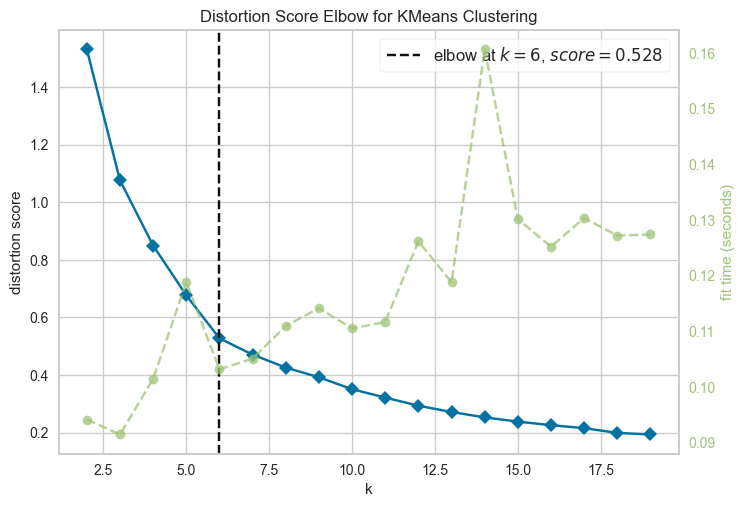

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [265]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2,20))
elbow.fit(loc_df.values)
elbow.show()

In [266]:
# inertia=[]
# for i in tqdm(range(1,20)):
#     kmeans = KMeans(n_clusters=i,random_state=0).fit(loc_df)
#     inertia.append(kmeans.inertia_)
# plt.plot(range(1,101),inertia, 'bx-')
# plt.title('Elbow method')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Inertia')
# plt.xticks(np.arange(0,101,5))
# plt.show()

In [267]:
# elbow_point = KneeLocator(range(1,101),inertia,curve='convex',direction='decreasing')
# print(elbow_point.knee)

### Modelling KMeans

In [268]:
kmeans = KMeans(n_clusters=6, random_state=0, n_init = 10,init='k-means++').fit(loc_df.values)


In [269]:
pickup = df[['pickup_long','pickup_lat']]
dropoff = df[['dropoff_long','dropoff_lat']]

pickup.columns = ['longitude','latitude']
dropoff.columns = ['longitude','latitude']

In [270]:
kmeans_prediction = kmeans.predict(loc_df.values)

loc_df['label'] = kmeans.labels_


### Evaluation Model KMeans

In [271]:
print('Silhouette score: {}'.format(round(silhouette_score(loc_df,kmeans_prediction),5)))

Silhouette score: 0.98001


### Visualization Model

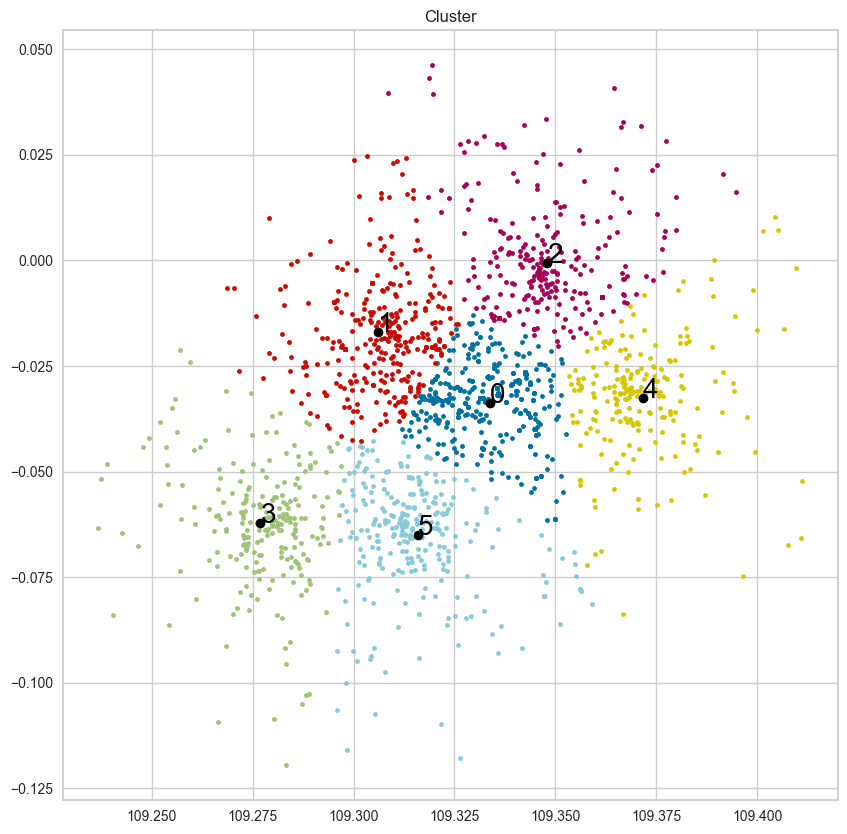

In [272]:
fig,ax = plt.subplots(figsize = (10,10))
for label in loc_df.label.unique():
    ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.')
    ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'black')
    ax.annotate(label, (kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1]), color = 'black', fontsize = 20)
ax.set_title('Cluster')
plt.show()

In [273]:
#First create an array of color schemes
colors = ['blue','red','beige','green','pink','orange']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
loc_df['color'] = vectorizer(kmeans_prediction)

loc_df.head()

,longitude,latitude,label,color
0,109.335633,-0.030186,0,blue
1,109.274206,-0.082877,3,green
2,109.288315,-0.027054,1,red
3,109.286232,-0.057977,3,green
4,109.310566,-0.012529,1,red


In [274]:
#location is the mean of every lat and long point to centre the map.
location = loc_df['latitude'].mean(), loc_df['longitude'].mean()

#A basemap is then created using the location to centre on and the zoom level to start.
m = folium.Map(location=location,zoom_start=15)

#Each location in the DataFrame is then added as a marker to the basemap points are then added to the map
for i in range(0,len(loc_df)):
    folium.Marker([loc_df['latitude'].iloc[i],loc_df['longitude'].iloc[i]],icon=folium.Icon(color=loc_df['color'].iloc[i])).add_to(m)
        
m

In [275]:
df['pickup_cluster'] = kmeans.predict(pickup)
df['dropoff_cluster'] = kmeans.predict(dropoff)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [276]:
clusters = pd.DataFrame()
clusters['x'] = kmeans.cluster_centers_[:,0]
clusters['y'] = kmeans.cluster_centers_[:,1]
clusters['label'] = range(len(clusters))

In [277]:
df['pickup_hour'] = pickup_hour

MovieWriter imagemagick unavailable; using Pillow instead.



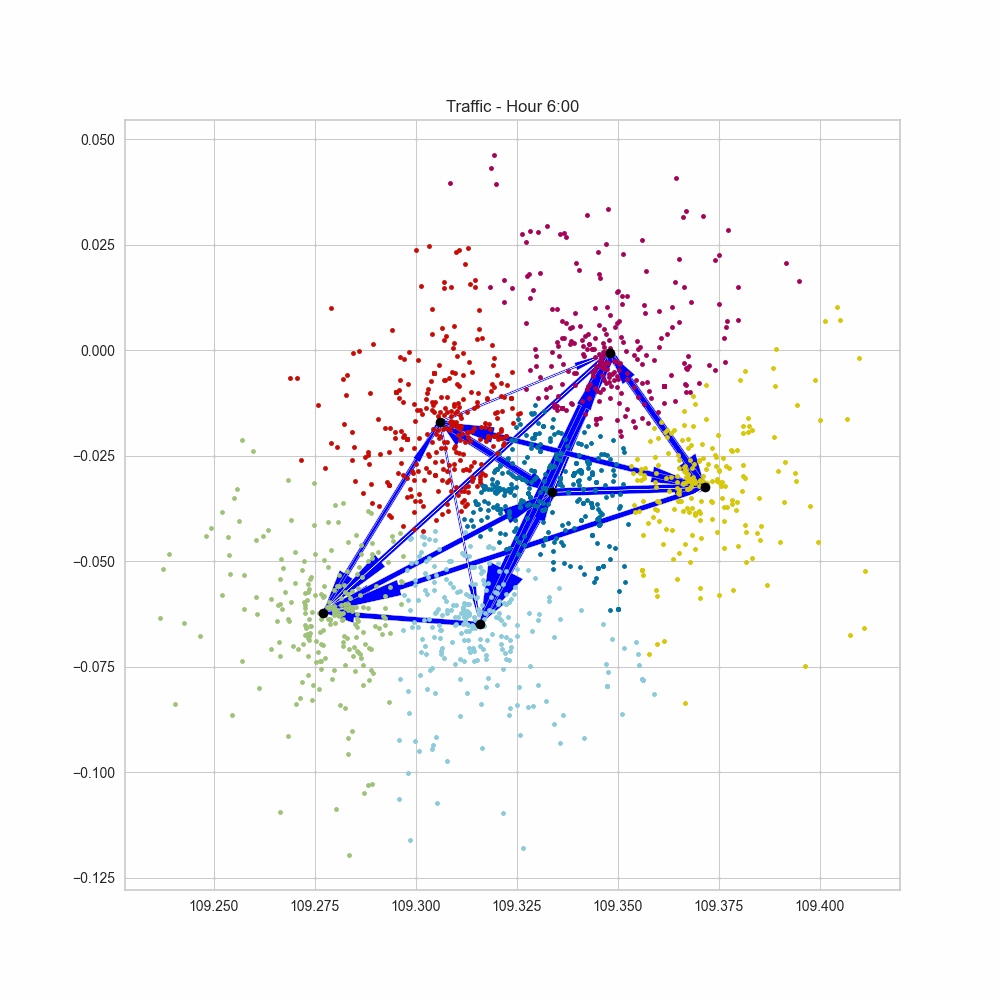

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [278]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))

def animate(hour):
    ax.clear()
    ax.set_title('Traffic - Hour ' + str(int(hour)) + ':00')    
    plt.figure(figsize = (10,10));
    for label in loc_df.label.unique():
        ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.');
        ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'black');


    for label in clusters.label:
        for dest_label in clusters.label:
            num_of_rides = len(df[(df.pickup_cluster == label) & (df.dropoff_cluster == dest_label) & (df.pickup_hour == hour)])
            dist_x = clusters.x[clusters.label == label].values[0] - clusters.x[clusters.label == dest_label].values[0]
            dist_y = clusters.y[clusters.label == label].values[0] - clusters.y[clusters.label == dest_label].values[0]
            pct = np.true_divide(num_of_rides,len(df))
            arr = Arrow(clusters.x[clusters.label == label].values, clusters.y[clusters.label == label].values, -dist_x, -dist_y, edgecolor='white', width = 3*pct)
            ax.add_patch(arr)
            arr.set_facecolor('blue')


ani = animation.FuncAnimation(fig,animate,sorted(df.pickup_hour.unique()), interval = 500)
plt.close()
ani.save('animation.gif', writer='imagemagick', fps=1)
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

# Linear Regression

##### Data Selection

In [279]:
# Hapus data tidak digunakan
df = df.drop(columns=['from_alamat','to_alamat','umur_customer','umur_driver','pickup_hour'])

# Penambahan atribut hasil output model kmeans; pickup dan dropoff cluster
df.head()

,mode,from_kelurahan,from_kecamatan,to_kelurahan,to_kecamatan,customer_gender,driver_gender,kendaraan_jenis,kendaraan_merk,merchant_name,merchant_category,golongan_customer,golongan_driver,pickup_lat,pickup_long,dropoff_lat,dropoff_long,distance,amount_delivery,amount_merchant,transaction_amount_total,Estimasi,Jam,Hari,Bulan,pickup_cluster,dropoff_cluster
525,3,10,1,27,4,1,1,1,10,4,4,2,1,-0.030186,109.335633,-0.017137,109.324104,0.257113,0.398467,0.937149,0.853053,0.422170,0.582680,0.841187,1.000000,0,1
886,0,5,3,9,4,1,0,1,6,50,2,1,0,-0.082877,109.274206,-0.056744,109.359527,0.799924,0.515050,0.000000,0.455332,0.595688,0.962633,0.333333,0.910752,3,4
810,0,23,0,6,5,1,1,1,4,50,2,2,0,-0.027054,109.288315,-0.019536,109.380904,0.816518,0.515050,0.000000,0.455332,0.836787,0.882512,0.881285,0.910752,1,4
278,1,2,3,10,1,1,1,0,9,50,2,1,0,-0.057977,109.286232,0.018280,109.330722,0.795791,0.898946,0.000000,0.700114,0.265792,0.962633,0.935785,1.000000,3,2
329,1,23,0,6,5,1,1,0,8,50,2,1,0,-0.012529,109.310566,-0.043036,109.374682,0.708327,0.849526,0.000000,0.668603,0.346578,0.000000,0.935785,1.000000,1,4


### Correlation Matrix

In [280]:
df.describe()

,mode,from_kelurahan,from_kecamatan,to_kelurahan,to_kecamatan,customer_gender,driver_gender,kendaraan_jenis,kendaraan_merk,merchant_name,merchant_category,golongan_customer,golongan_driver,pickup_lat,pickup_long,dropoff_lat,dropoff_long,distance,amount_delivery,amount_merchant,transaction_amount_total,Estimasi,Jam,Hari,Bulan,pickup_cluster,dropoff_cluster
count,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000
mean,1.297556,13.629118,2.185972,13.730074,2.564293,0.524973,0.279490,0.763018,4.263549,42.238045,2.426142,1.478215,0.350691,-0.033345,109.325836,-0.033917,109.324738,0.528601,0.551742,0.416650,0.649808,0.570108,0.576332,0.702956,0.742434,1.777896,2.521785
std,1.112159,7.959844,1.658138,8.156543,1.719525,0.499641,0.448987,0.425457,3.123119,16.990381,1.313642,0.552368,0.477440,0.022637,0.027106,0.027510,0.031538,0.194623,0.198572,0.473838,0.252528,0.226552,0.295547,0.254255,0.370447,1.749948,1.743317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.119578,109.247987,-0.115993,109.236708,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7.000000,1.000000,7.000000,1.000000,0.000000,0.000000,1.000000,2.000000,34.000000,2.000000,1.000000,0.000000,-0.047809,109.308525,-0.056324,109.305755,0.402412,0.398467,0.000000,0.421905,0.407020,0.379952,0.566813,0.370310,0.000000,1.000000
50%,1.000000,12.000000,2.000000,13.000000,3.000000,1.000000,0.000000,1.000000,4.000000,50.000000,2.000000,2.000000,0.000000,-0.031500,109.330276,-0.032040,109.320783,0.531040,0.559375,0.000000,0.668603,0.595688,0.640678,0.819811,0.910752,1.000000,2.000000
75%,2.000000,20.000000,3.000000,21.000000,4.000000,1.000000,1.000000,1.000000,7.000000,50.000000,4.000000,2.000000,1.000000,-0.018418,109.344327,-0.014891,109.346668,0.672316,0.689346,0.951176,0.892216,0.756212,0.839393,0.900147,1.000000,3.000000,4.000000
max,3.000000,28.000000,5.000000,28.000000,5.000000,1.000000,1.000000,1.000000,10.000000,76.000000,5.000000,2.000000,1.000000,0.040750,109.398942,0.046226,109.411174,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000


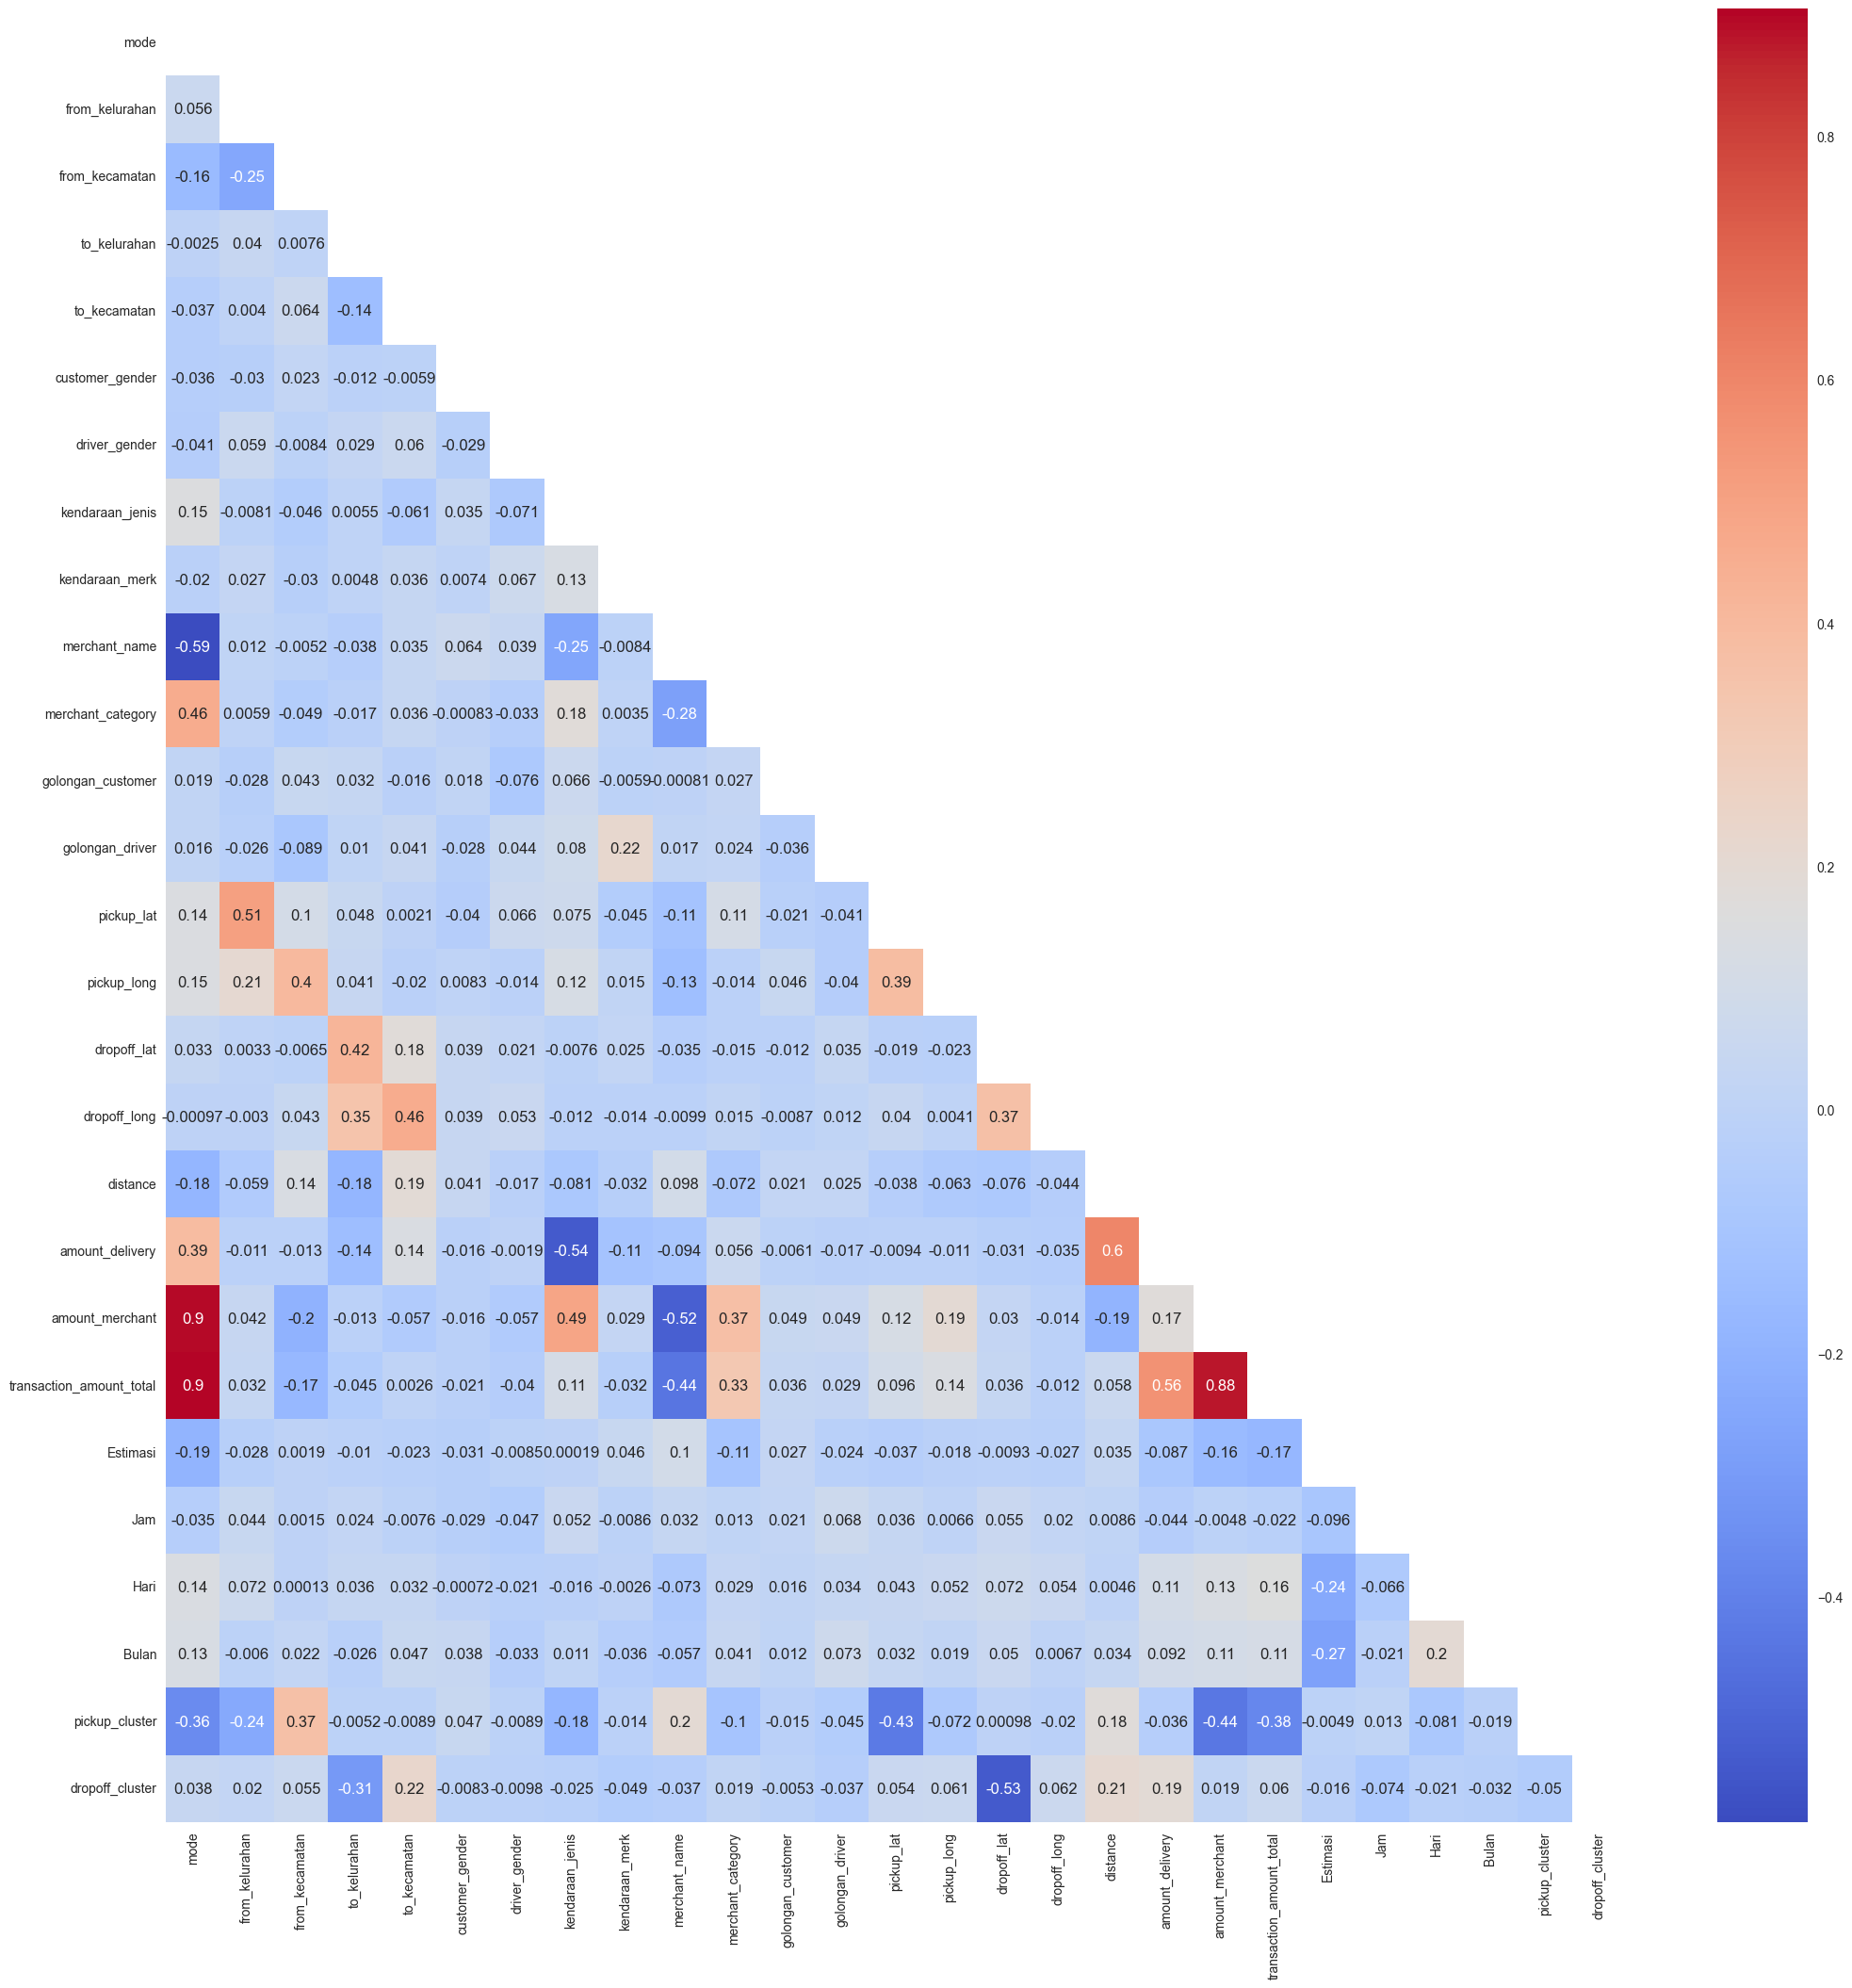

In [281]:
corr_matrix = df.corr()

# Membuat matriks dengan elemen diagonal dan atasnya diisi dengan False
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(25, 25))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=mask)
plt.show()

### Modelling Linear Regression

In [282]:
x = df.drop(columns=['transaction_amount_total'])
y = df.transaction_amount_total

In [283]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=.25,random_state=12)

In [284]:
# Inisialisasi model
model = LinearRegression()

# Latih model
model.fit(xtrain, ytrain)

LinearRegression()

In [285]:
# Menampilkan koefisien dari setiap fitur pada model
coefficients = pd.DataFrame(model.coef_, x.columns)
coefficients.columns = ['Slope']
print(coefficients)


                      Slope
mode              -0.010032
from_kelurahan     0.000200
from_kecamatan     0.002351
to_kelurahan       0.000254
to_kecamatan      -0.000427
customer_gender    0.001374
driver_gender     -0.005318
kendaraan_jenis   -0.414705
kendaraan_merk    -0.000079
merchant_name      0.000020
merchant_category  0.000020
golongan_customer  0.003242
golongan_driver    0.000923
pickup_lat         0.055434
pickup_long       -0.233543
dropoff_lat       -0.015703
dropoff_long       0.044788
distance           0.581452
amount_delivery   -0.388718
amount_merchant    0.750649
Estimasi          -0.003567
Jam               -0.007182
Hari              -0.000726
Bulan             -0.005340
pickup_cluster     0.000396
dropoff_cluster   -0.002603


In [286]:
# Menampilkan slope dan intercept
print("Intercept:", model.intercept_)

Intercept: 21.21323729389979


In [287]:
# Menghitung hasil prediksi pada dataset pengujian
y_pred = model.predict(xtest)

# Menghitung metrik evaluasi
mse = mean_squared_error(ytest, y_pred)
mae = mean_absolute_error(ytest, y_pred)
mape = mean_absolute_percentage_error(ytest,y_pred)
r2 = r2_score(ytest, y_pred)

# Menghitung jumlah sampel dan jumlah fitur
n_samples, n_features = xtest.shape

# Menghitung adjusted R-squared score
adj_r2 = 1 - (1 - r2) * ((n_samples - 1) / (n_samples - n_features - 1))

# Mencetak hasil evaluasi
print('Mean Squared Error :', mse)
print('Mean Absolute Error :', mae)
print('Mean Absolute Percentage Error :', mape)
print('R-Squared :', r2)
print('Adj-R-Squared :', adj_r2)

Mean Squared Error : 0.0022923654559598625
Mean Absolute Error : 0.0361544499979105
Mean Absolute Percentage Error : 0.07407659204655417
R-Squared : 0.963672489659596
Adj-R-Squared : 0.9591532778469141
